### Problems need to be comfired

1. How to generate M? 
2. Given output of conv4_3 layer, how to generate M_hat?
3. Does selected feature maps indexes are fixed arcoss all imgs in a video?


probel: sel_cnn loss can not decrease
idea1: change scale factor of the mask
idea2: change data

In [1]:
import tensorflow as tf
import numpy as np
import skimage
import skimage.io
import skimage.transform

show = skimage.io.imshow
%matplotlib inline


import matplotlib.pyplot as plt
import scipy.stats as st
import os
import sys

from vgg16 import vgg16
from sel_CNN import selCNN
from input_producer import InputProducer
from utils import extract_roi, gen_mask, img_with_bbox, print_prob


In [2]:
from scope_test import t1, t2
from utils import variable_on_cpu, variable_with_weight_decay

In [4]:
data_path = 'data/Dog1/'
img_path = os.path.join(data_path, 'img')

# read bbox from file 
gt_fn = os.path.join(data_path, 'groundtruth_rect.txt')

input_producer = InputProducer(img_path, gt_fn)


In [5]:
img, gt, idx  = next(input_producer.gen_img)
show(img)

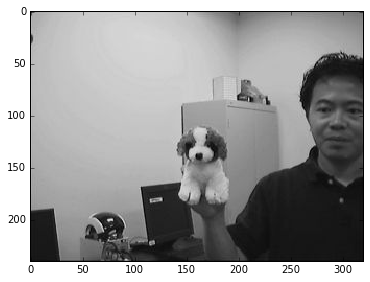

In [6]:
show(img)

/home/xlws/repos/FCNT_TF/input_producer.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [self.roi_params['roi_size'], self.roi_params['roi_size']], interp='bicubic')


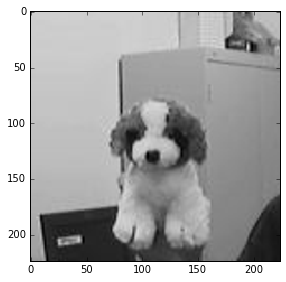

In [7]:

roi, roi_pos, preimg, pad = input_producer.extract_roi(img, gt)
#roi, _,_ =extract_roi_old(img_origin, gt_1, roi_size)
skimage.io.imshow(roi)

In [8]:
fea_sz = (28, 28)
#mask = gen_mask(img_origin.shape, fea_sz, roi_size, gt_1, [0,0], s1)
gt_M = input_producer.gen_mask(fea_sz)

0.0013186425201 max of mask
(224, 224, 3)
248 max convas


/home/xlws/repos/FCNT_TF/input_producer.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [self.roi_params['roi_size'], self.roi_params['roi_size']], interp='bicubic')


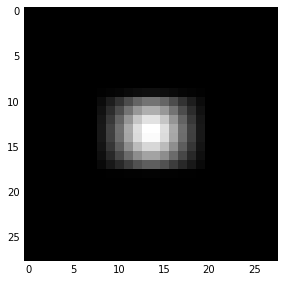

In [9]:
show(gt_M)

In [10]:

sess = tf.Session()
sess.run(tf.initialize_all_variables())
vgg = vgg16('vgg16_weights.npz', sess)

vgg.print_prob(roi, sess)


Old English sheepdog, bobtail 0.707142
Tibetan terrier, chrysanthemum dog 0.0368377
Sealyham terrier, Sealyham 0.0362287
miniature poodle 0.028478
standard poodle 0.0153578


In [11]:
vgg.img_porcessed.shape

(224, 224, 3)

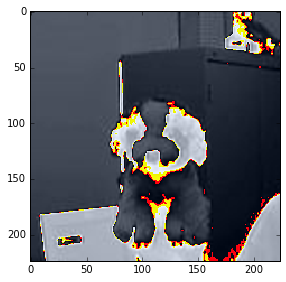

In [12]:
show(vgg.img_porcessed.astype(np.uint8))

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


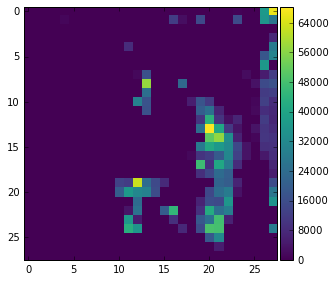

In [13]:
# visual conv layer
conv4_3 = vgg.conv4_3
conv5_3 = vgg.conv5_3
feed_dict={vgg.imgs: [roi]}
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    res4, res5 = sess.run([conv4_3, conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

In [14]:

l_selcnn = selCNN('local', conv4_3)
pre_M_tensor = l_selcnn.pre_M
train_op, losses, lr, optimizer = l_selcnn.train(gt_M)

sess = tf.Session()
sess.run(tf.initialize_all_variables())


In [75]:
pre_M_tensor.get_shape().as_list()[1:3]

[28, 28]

In [15]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['Const',
 'init',
 'Placeholder',
 'vgg/preprocess/img_mean',
 'vgg/preprocess/sub',
 'vgg/conv1_1/truncated_normal/shape',
 'vgg/conv1_1/truncated_normal/mean',
 'vgg/conv1_1/truncated_normal/stddev',
 'vgg/conv1_1/truncated_normal/TruncatedNormal',
 'vgg/conv1_1/truncated_normal/mul',
 'vgg/conv1_1/truncated_normal',
 'vgg/conv1_1/weights',
 'vgg/conv1_1/weights/Assign',
 'vgg/conv1_1/weights/read',
 'vgg/conv1_1/Conv2D',
 'vgg/conv1_1/Const',
 'vgg/conv1_1/biases',
 'vgg/conv1_1/biases/Assign',
 'vgg/conv1_1/biases/read',
 'vgg/conv1_1/BiasAdd',
 'vgg/conv1_1',
 'vgg/conv1_2/truncated_normal/shape',
 'vgg/conv1_2/truncated_normal/mean',
 'vgg/conv1_2/truncated_normal/stddev',
 'vgg/conv1_2/truncated_normal/TruncatedNormal',
 'vgg/conv1_2/truncated_normal/mul',
 'vgg/conv1_2/truncated_normal',
 'vgg/conv1_2/weights',
 'vgg/conv1_2/weights/Assign',
 'vgg/conv1_2/weights/read',
 'vgg/conv1_2/Conv2D',
 'vgg/conv1_2/Const',
 'vgg/conv1_2/biases',
 'vgg/conv1_2/biases/Assign',
 'vgg/conv

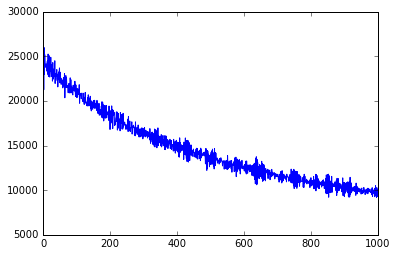

In [17]:
max_itertimes = 1000
loss = []
imgs = []
lrt = []
for i in range(max_itertimes):
    # update weights
    _, total_loss, pre_M, lr_ = sess.run([train_op, losses, pre_M_tensor, lr], feed_dict=feed_dict)
    
    # visualize predicted heat map
    sys.stdout.flush()
    #print('loss: ',total_loss)
    loss.append(total_loss)
    lrt.append(lr_)
    if i % 50==0:
        imgs.append(pre_M)
    #plt.imshow(pre_M[0,:,:,0])
plt.plot(loss)

In [18]:
loss[:10]

[15000.845,
 26697.475,
 21246.309,
 25971.871,
 22973.211,
 25172.834,
 24003.262,
 23769.828,
 23780.391,
 24145.812]

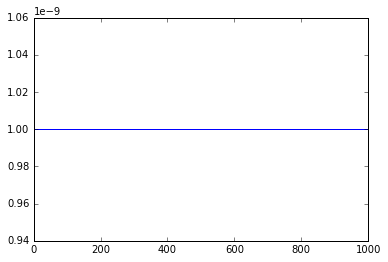

In [19]:
plt.plot(lrt)

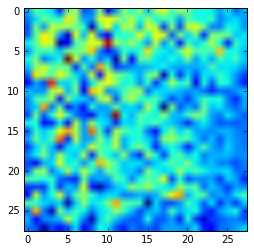

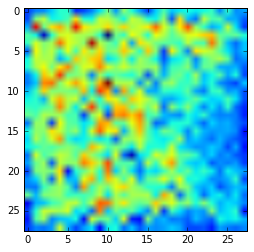

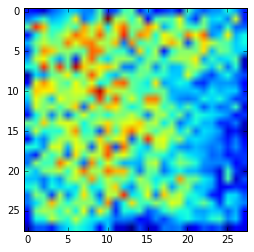

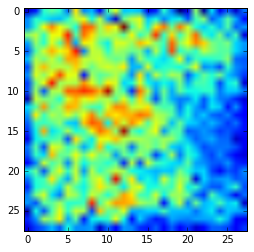

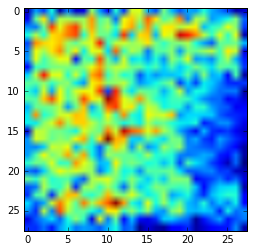

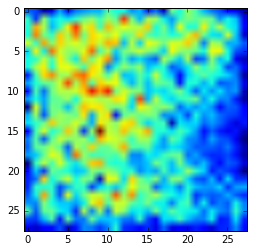

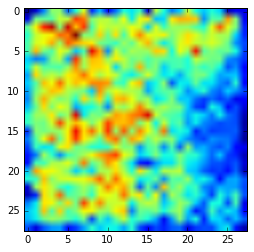

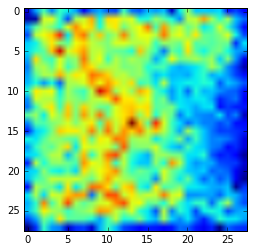

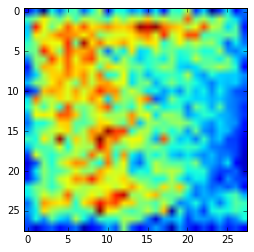

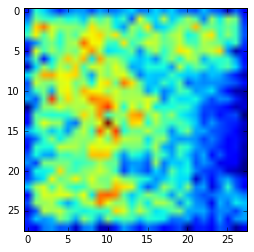

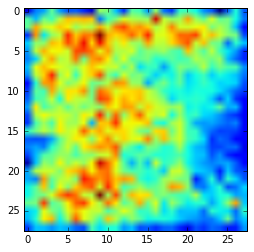

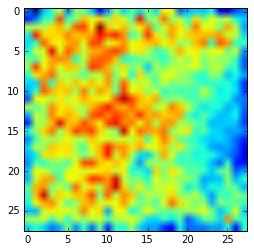

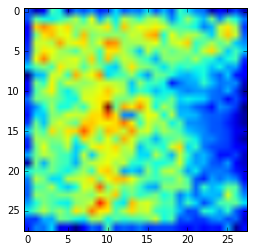

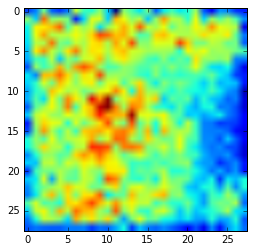

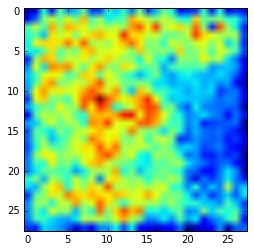

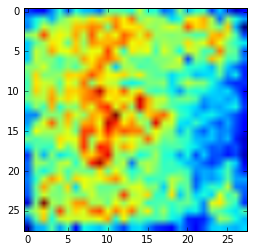

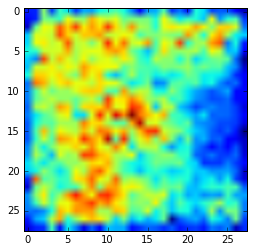

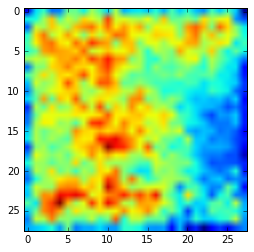

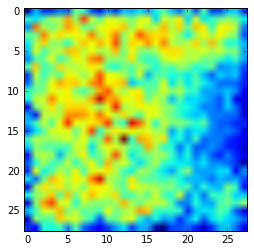

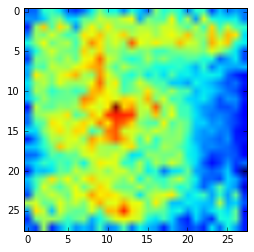

In [20]:
for img in imgs:
    plt.figure()
    plt.imshow(img[0,:,:,0])

In [21]:
loss[-1]

9986.8945

## Computes saiency maps


function [sal, id] = compute_saliency(fea1, map, solver)
caffe('set_phase_test');
if strcmp(solver, 'ssolver')
    out = caffe('forward_snet', fea1);
    diff1 = {out{1}-permute(single(map), [2,1,3])};  % loss
    input_diff1 = caffe('backward_snet', diff1);  % 
    diff2 = {single(ones(size(fea1{1},1)))};
    input_diff2 = caffe('backward2_snet', diff2);
elseif strcmp(solver, 'gsolver')
    out = caffe('forward_gnet', fea1);
    diff2 = {single(ones(size(fea1{1},1)))};
    diff1 = {out{1}-permute(single(map), [2,1,3])};
    input_diff1 = caffe('backward_gnet', diff1);
    input_diff2 = caffe('backward2_gnet', diff2);
else
    error('Unkonwn solver type')
end
% sal = sum(sum(input_diff2{1}.*(fea1{1}).^2));
% sal = -sum(sum(input_diff1{1}.*fea1{1}))+0.5*sum(sum(input_diff2{1}.*(fea1{1}).^2));
sal = -sum(sum(input_diff1{1}.*fea1{1}+0.5*input_diff2{1}.*(fea1{1}).^2));
sal = sal(:);
[~, id] = sort(sal, 'descend');
end

In [ ]:
# S = -GF + 0.5 * H * F**2
# where G is partial derivative of L(sel-CNN) with respect to F feature
# maps of vgg. H is a diagnal part of the Hessian matrix, which can be 
# computed by back probpagation twice with respect to the feature maps.



In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [30]:
F = vgg.kernel4_3
G = tf.gradients(losses, F)

In [43]:
H = tf.gradients(G, F)

In [ ]:
S = - tf.reduce_sum(G, reduction_indices=[0,1,2]) 

In [71]:
S

<tf.Tensor 'Neg_1:0' shape=(512,) dtype=float32>

In [70]:
tf.diag_part(S)

ValueError: Input must have even rank <= 6, input rank is 1

In [66]:
S = - tf.reduce_sum(G, reduction_indices=[0,1,2, 3]) 

In [46]:
grads , Hessian = sess.run([G, H], feed_dict=feed_dict)

In [29]:
losses

<tf.Tensor 'local_1/total_losses:0' shape=() dtype=float32>

In [23]:
G

[(<tf.Tensor 'gradients/vgg/conv4_3/Conv2D_grad/tuple/control_dependency_1:0' shape=(3, 3, 512, 512) dtype=float32>,
  <tensorflow.python.ops.variables.Variable at 0x7f24fc074a58>)]